### Importing Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [19]:
# import pickle
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, MinMaxScaler, StandardScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, log_loss
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

## EDA

#### Loading and Spliting Dataset

In [20]:
train_data = pd.read_csv("D:/Projects/MLP24T3/data/train.csv")
test_data = pd.read_csv("D:/Projects/MLP24T3/data/test.csv")

In [21]:
train, test = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data.target)

X_train = train.drop('target', axis=1)
y_train = train['target'].copy(deep=True)

X_test = test.drop('target', axis=1)
y_test = test['target'].copy(deep=True)

#### Encoding **Label**

In [22]:
lb = LabelEncoder()
y_train_enc = lb.fit_transform(y_train)
y_test_enc = lb.transform(y_test)

(39211, 16) (31368,) (7843,)


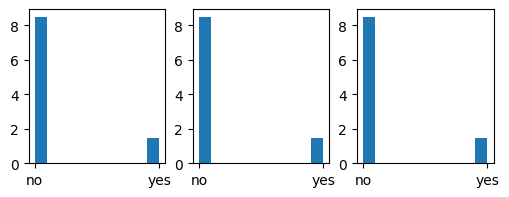

In [8]:
print(train_data.shape, y_train.shape, y_test.shape)
assert train_data.shape[0] == y_train.shape[0] + y_test.shape[0]

plt.figure(figsize=(6, 2))

plt.subplot(1, 3, 1)
plt.hist(train_data.target, density=True)
plt.subplot(1, 3, 2)
plt.hist(y_train, density=True)
plt.subplot(1, 3, 3)
plt.hist(y_test, density=True)

plt.show()

#### Analysing Features

In [ ]:
def var_skew_kurt(arr):
  print(f'Var: {arr.var()}\n Skew: {arr.skew()}\n Kurt: {arr.kurt()}')

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31368 entries, 11002 to 38130
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  31368 non-null  object
 1   age                31368 non-null  int64 
 2   job                31182 non-null  object
 3   marital            31368 non-null  object
 4   education          30205 non-null  object
 5   default            31368 non-null  object
 6   balance            31368 non-null  int64 
 7   housing            31368 non-null  object
 8   loan               31368 non-null  object
 9   contact            23107 non-null  object
 10  duration           31368 non-null  int64 
 11  campaign           31368 non-null  int64 
 12  pdays              31368 non-null  int64 
 13  previous           31368 non-null  int64 
 14  poutcome           7815 non-null   object
dtypes: int64(6), object(9)
memory usage: 3.8+ MB


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='age', ylabel='duration'>

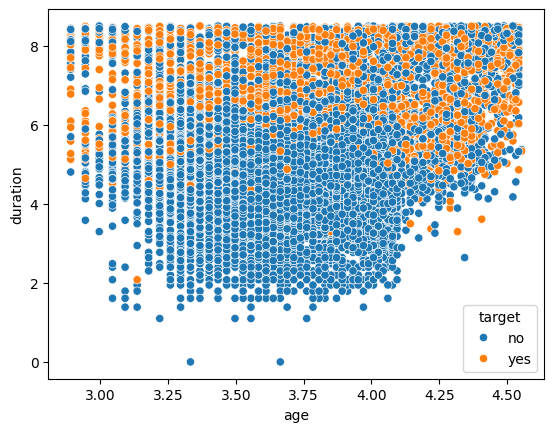

In [ ]:
from pickle import dump
age = np.log(X_train.age)
duration = np.log(X_train.duration)
balance = np.log(X_train.balance)
sns.scatterplot(data=train, x=age, y=duration, hue='target')

#### For Age
1. Ln() Tranformation
2. StandardScaler
3. No outlier Management

Distribution of Age


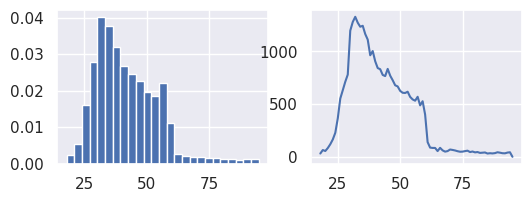

Distribution of log Age


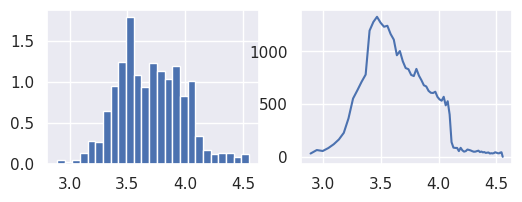

In [ ]:
print('Distribution of Age')
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.hist(X_train.age, bins=25, density=True)
plt.subplot(1, 2, 2)
plt.plot(X_train.age.value_counts().sort_index())
plt.show()

print('Distribution of log Age')
age = np.log(X_train.age)
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.hist(age, bins=25, density=True)
plt.subplot(1, 2, 2)
plt.plot(age.value_counts().sort_index())
plt.show()

In [ ]:
var_skew_kurt(X_train.age)
var_skew_kurt(age)

Var: 162.06313366177224
 Skew: 1.1283510592708734
 Kurt: 1.7950714985778018
Var: 0.08149341407694524
 Skew: 0.2708628064405603
 Kurt: -0.09124771339238391


#### For balance

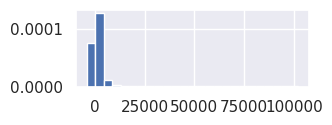

count     31368.000000
mean       5419.414786
std       16308.905670
min       -4057.000000
25%          98.000000
50%         548.000000
75%        2017.000000
max      102127.000000
Name: balance, dtype: float64 

Var: 265980404.15564492
 Skew: 4.074625219233398
 Kurt: 16.423425734072282


In [ ]:
plt.figure(figsize=(3, 1))
plt.hist(X_train.balance, bins=25, density=True)
plt.show()

print(X_train.balance.describe(), '\n')
var_skew_kurt(X_train.balance)

In [ ]:
balance = X_train.balance.copy(deep=True)
freq_table = balance.value_counts().sort_index()

balance = balance + abs(balance.min()) + 1e-6
print((balance <= 0).sum())
balance = np.log(balance)

0


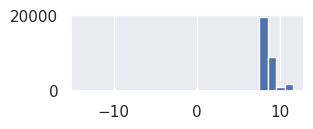

count    31368.000000
mean         8.703931
std          0.715661
min        -13.815511
25%          8.332068
50%          8.434898
75%          8.711773
max         11.572929
Name: balance, dtype: float64 

Var: 0.5121711183048795
 Skew: 1.478674638473311
 Kurt: 36.94293972029308


In [ ]:
plt.figure(figsize=(3, 1))
plt.hist(balance, bins=25)
plt.show()

print(balance.describe(), '\n')
var_skew_kurt(balance)

In [ ]:
median = balance.median()
iqr = balance.quantile(0.75) - balance.quantile(0.25)
outlier_indices = balance[(balance < balance.quantile(0.25) - 1.5 * iqr) | (balance > balance.quantile(0.75) + 1.5 * iqr)].index
balance.loc[outlier_indices] = median

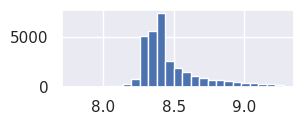

count    31368.000000
mean         8.479736
std          0.216378
min          7.778630
25%          8.332308
50%          8.434898
75%          8.545003
max          9.281172
Name: balance, dtype: float64 

Var: 0.0468195373007865
 Skew: 1.4936157052883974
 Kurt: 2.1499262023239925


In [ ]:
plt.figure(figsize=(3, 1))
plt.hist(balance, bins=25)
plt.show()

print(balance.describe(), '\n')
var_skew_kurt(balance)

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest

In [ ]:
robust_scaler = RobustScaler().set_output(transform='pandas')
min_max_scaler = MinMaxScaler().set_output(transform='pandas')
standard_scaler = StandardScaler().set_output(transform='pandas')

In [ ]:
balance = balance.to_frame()
balance_robust = robust_scaler.fit_transform(balance)
balance_min_max = min_max_scaler.fit_transform(balance)
balance_standard = standard_scaler.fit_transform(balance)

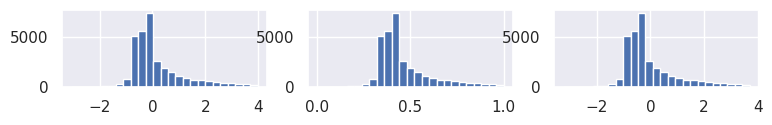

In [ ]:
plt.figure(figsize=(9, 1))
plt.subplot(1, 3, 1)
plt.hist(balance_robust, bins=25)
plt.subplot(1, 3, 2)
plt.hist(balance_min_max, bins=25)
plt.subplot(1, 3, 3)
plt.hist(balance_standard, bins=25)
plt.show()

#### For Pdays

count    31368.000000
mean        71.673712
std        159.629253
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64
Var: 25481.49830850126
 Skew: 2.618003628211177
 Kurt: 6.988379525733622


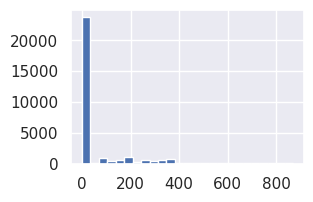

In [ ]:
pdays = X_train.pdays.copy(deep=True)

print(pdays.describe())
var_skew_kurt(pdays)

plt.figure(figsize=(3, 2))
plt.hist(pdays, bins=25)
plt.show()

<Axes: xlabel='pdays', ylabel='target'>

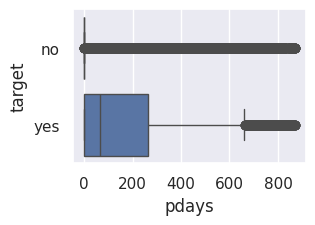

In [ ]:
sns.set(rc={'figure.figsize':(3, 2)})
sns.boxplot(data=train, x='pdays', y='target')

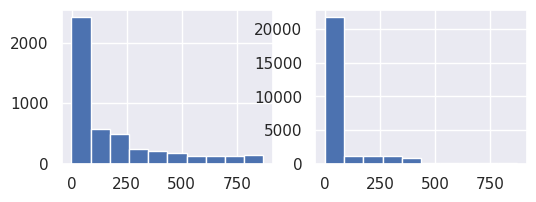

In [ ]:
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.hist(train.loc[train.target == 'yes', 'pdays'])
plt.subplot(1, 2, 2)
plt.hist(train.loc[train.target == 'no', 'pdays'])
plt.show()

In [ ]:
# prompt: write a statitical test for dpendence of contious variable pdays and y_train

from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(X_train['pdays'], y_train_enc)

print("Pearson correlation coefficient:", correlation)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
  print("There is a statistically significant correlation between pdays and target (reject the null hypothesis)")
else:
  print("There is no statistically significant correlation between pdays and target (fail to reject the null hypothesis)")

Pearson correlation coefficient: 0.25515630275705825
P-value: 0.0
There is a statistically significant correlation between pdays and target (reject the null hypothesis)


<Axes: xlabel='pdays', ylabel='target'>

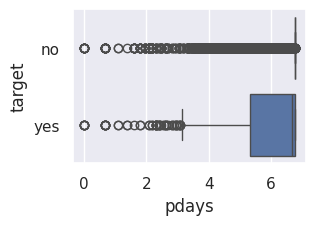

In [ ]:
pdays_trans = pdays.replace(-1, pdays.max())
pdays_trans = np.log(pdays_trans.replace(0, 1))

sns.set(rc={'figure.figsize':(3, 2)})
sns.boxplot(data=train, x=pdays_trans, y='target')

<Axes: xlabel='pdays', ylabel='target'>

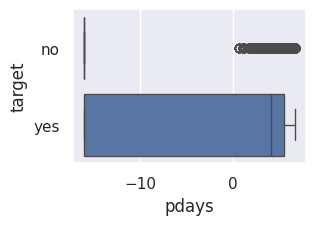

In [ ]:
pdays_trans = pdays + 1 + 1e-7
pdays_trans = np.log(pdays_trans)

sns.set(rc={'figure.figsize':(3, 2)})
sns.boxplot(data=train, x=pdays_trans, y='target')

In [ ]:
pdays_trans.isna().sum()

0

In [ ]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(pdays_trans, y_train_enc)

print("Pearson correlation coefficient:", correlation)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
  print("There is a statistically significant correlation between pdays and target (reject the null hypothesis)")
else:
  print("There is no statistically significant correlation between pdays and target (fail to reject the null hypothesis)")

Pearson correlation coefficient: 0.2713080836023952
P-value: 0.0
There is a statistically significant correlation between pdays and target (reject the null hypothesis)


##### Can we use KBinsDiscretizer

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans').set_output(transform='pandas')
kbd.fit(pdays.values.reshape(-1, 1))

KBinsDiscretizer(encode='ordinal', strategy='kmeans')

In [ ]:
pdays_trans = kbd.transform(pdays.values.reshape(-1, 1))

<Axes: xlabel='x0', ylabel='target'>

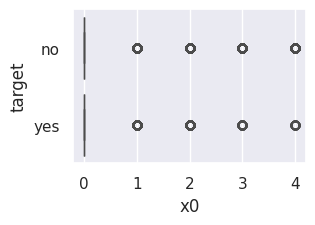

In [ ]:
sns.set(rc={'figure.figsize':(3, 2)})
sns.boxplot(data=train, x=pdays_trans.iloc[:, 0], y='target')

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(pdays_trans.iloc[:, 0], y_train)

chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

alpha = 0.05
if p < alpha:
  print("The variables are dependent (reject the null hypothesis)")
else:
  print("The variables are independent (fail to reject the null hypothesis)")

Chi-squared statistic: 1.1715485955944382
P-value: 0.8827603727097532
The variables are independent (fail to reject the null hypothesis)


##### Should we use MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mms = MinMaxScaler().set_output(transform='pandas')
pdays_trans = mms.fit_transform(pdays.values.reshape(-1, 1))

In [ ]:
pdays_trans

,x0
0,0.314220
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
31363,0.000000
31364,0.813073
31365,0.000000
31366,0.000000


In [ ]:
pdays_trans = pd.DataFrame(pdays_trans)

In [ ]:
MinMaxScaler().set_output(transform='pandas').fit_transform(pdays_trans).isna().sum()

,0
x0,0


In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(pdays_trans.iloc[:, 0], y_train)

chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p)


alpha = 0.05
if p < alpha:
  print("The variables are dependent (reject the null hypothesis)")
else:
  print("The variables are independent (fail to reject the null hypothesis)")

Chi-squared statistic: 771.0652488484378
P-value: 0.9179109852450844
The variables are independent (fail to reject the null hypothesis)


#### RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
rs = RobustScaler().set_output(transform='pandas')
pdays_trans = rs.fit_transform(pdays.values.reshape(-1, 1))

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(pdays_trans.iloc[:, 0], y_train)

chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p)


alpha = 0.05
if p < alpha:
  print("The variables are dependent (reject the null hypothesis)")
else:
  print("The variables are independent (fail to reject the null hypothesis)")

Chi-squared statistic: 771.0652488484378
P-value: 0.9179109852450844
The variables are independent (fail to reject the null hypothesis)


# how does knowing distriution of a feature helps in ml


## How Knowing the Distribution of a Feature Helps in ML

Understanding the distribution of a feature in your dataset is crucial for building effective machine learning models. Here's why:

**1. Feature Engineering and Transformation:**

* **Identifying Outliers:** Distributions can reveal outliers, which are data points significantly different from the rest. Outliers can negatively impact model performance. You can choose to remove them, transform them, or treat them differently based on the distribution.
* **Handling Skewness:** Features with skewed distributions might need transformation (e.g., log transformation) to normalize them and improve model performance.
* **Feature Scaling:** Knowing the distribution can guide you in choosing the appropriate scaling technique. For example, features with normal distributions can be standardized, while features with skewed distributions might benefit from robust scaling.
* **Feature Selection:** Features with little variance or a uniform distribution may not be informative for the model and can be removed.


**2. Model Selection:**

* **Choosing the Right Algorithm:** Different machine learning algorithms are sensitive to different types of data distributions. For example, linear models assume that features are normally distributed, while tree-based models are less sensitive to distribution assumptions.
* **Hyperparameter Tuning:** Understanding the distribution of features can inform the choice of appropriate hyperparameters for the model. For instance, the choice of regularization parameters can be influenced by the distribution of the data.

**3. Model Evaluation and Interpretation:**

* **Evaluating Model Performance:** Some evaluation metrics are more appropriate for certain distributions. For example, using Mean Squared Error (MSE) might be suitable for normally distributed data, while other metrics may be better for other types of distributions.
* **Understanding Model Predictions:** Feature distributions can help you interpret model predictions. If a feature has a skewed distribution, you may find that the model is more accurate in predicting the majority class or the central part of the distribution.

**In your context, analyzing the distribution of features like `age`, `balance`, `last contact date` and `job` helps you:**

* **Identify potential outliers in `age` and `balance`.** You can decide whether to remove them or treat them separately.
* **Choose appropriate scaling techniques for `age` and `balance`, considering their skewness.**
* **Understand the frequency and time periods of bank calls by examining the distribution of `last contact date`.** You can discover insights about call patterns and effectiveness during different months or days.
* **Perform One Hot Encoding for the `job` feature if it has a categorical distribution with relatively few distinct values.**

By analyzing the distributions of your features, you gain valuable insights that help you build better-performing, more robust, and more interpretable machine learning models.


# Preprocessing

In [23]:
class IQROutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        for column in X.columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            self.lower_bound = Q1 - self.factor * IQR
            self.upper_bound = Q3 + self.factor * IQR
            self.median_val = X[column].median()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for column in X.columns:
          X_copy.loc[((X_copy[column] < self.lower_bound) | (X_copy[column] > self.upper_bound)), column] = self.median_val
        return X_copy

    def set_output(self, **kwargs):
        return self

In [24]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform=None):
        self.columns_to_transform = columns_to_transform

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        X_transformed['last contact date'] = pd.to_datetime(X_transformed['last contact date'])
        X_transformed['date'] = (X_transformed['last contact date'].dt.day - 1)/29
        X_transformed['month'] = (X_transformed['last contact date'].dt.month - 1)/11
        X_transformed['year'] = X_transformed['last contact date'].dt.year
        X_transformed = X_transformed.drop('last contact date', axis=1)

        X_transformed['balance'] = X_transformed['balance'] + abs(X_transformed['balance'].min()) + 1e-6

        # X_transformed['pdays'] = X_transformed['pdays'].replace(-1, np.nan)
        # X_transformed['pdays'] = X_transformed['pdays'].replace(-1, X_transformed.pdays.max())
        # X_transformed['pdays'] = X_transformed['pdays'].replace(0, 1)
        # X_transformed['pdays'] = np.log(X_transformed['pdays'])

        X_transformed['pdays'] = X_transformed['pdays'].map(lambda x: np.log1p(x + 1e-6))

        X_transformed['poutcome'] = X_transformed['poutcome'].fillna('unknown')

        X_transformed['duration'] = np.log(X_transformed['duration'].replace(0, 1))
        X_transformed['age'] = np.log(X_transformed['age'])

        return X_transformed
    def set_output(self, **kwargs):
        return self

imputaion for job, education , contact,

In [25]:
balance_pipe = make_pipeline(
    FunctionTransformer(np.log),
    IQROutliersTransformer(),
    StandardScaler()
)

job_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse_output=False)
)

edu_con_pipe = make_pipeline(
    OrdinalEncoder(),
    KNNImputer(n_neighbors=1),
    OneHotEncoder(drop='if_binary', sparse_output=False)
)

In [26]:
preprocessing = ColumnTransformer([
    ('oe', OrdinalEncoder(), ['default', 'housing', 'loan', 'poutcome']),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False), ['marital']),
    ('mms', MinMaxScaler(), ['year', 'duration', 'campaign', 'previous', 'pdays']),
    ('balance_pipe', balance_pipe, ['balance']),
    ('ss', StandardScaler(), ['age']),
    ('job_pipe', job_pipe, ['job']),
    ('edu_con_pipe', edu_con_pipe, ['education', 'contact']),
], remainder='passthrough').set_output(transform='pandas')

In [13]:
# feature_trans = make_pipeline(CustomTransformer(), encoder_scaler)
# x_trans = feature_trans.fit_transform(X_train)
# t = x_trans.isna().sum()
# t[t > 0 ]

# Logistic Regression

In [11]:
pipe_lr = Pipeline([
    ('customise', CustomTransformer()),
    ('preProccessing', preprocessing),
    ('logisticRegression', LogisticRegression())
])

In [ ]:
# pipe_lr[-1].get_params().keys()

In [12]:
param_grid = {
    'logisticRegression__C': [10, 1, 1e-1, 1e-2],
    'logisticRegression__max_iter': [100, 500],
    'logisticRegression__solver': ['saga'],
    'logisticRegression__penalty': ['l1', 'l2', 'balanced'],
    'logisticRegression__class_weight': ['balanced', None],
}

gscv = GridSearchCV(param_grid=param_grid, estimator=pipe_lr, scoring='f1_macro', cv=5)

In [13]:
gscv.fit(X_train, y_train_enc)
# file_name = 'best_lr.sav'
# pickle.dump(gscv.best_estimator_, open(file_name, 'wb'))
# files.download(file_name)

C:\Users\Lokesh Tiwari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Lokesh Tiwari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Lokesh Tiwari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Lokesh Tiwari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Lokesh Tiwari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('customise', CustomTransformer()),
                                       ('preProccessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oe',
                                                                         OrdinalEncoder(),
                                                                         ['default',
                                                                          'housing',
                                                                          'loan',
                                                                          'poutcome']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['marital']),
                                                                        ('mms',
                                                                         MinMaxScaler(),
                                                                         ['year',
                                                                          'duration',
                                                                          'campaign',
                                                                          'previous',
                                                                          'pd...
                                                                                                        sparse_output=False))]),
                                                                         ['education',
                                                                          'contact'])])),
                                       ('logisticRegression',
                                        LogisticRegression())]),
             param_grid={'logisticRegression__C': [10, 1, 0.1, 0.01],
                         'logisticRegression__class_weight': ['balanced', None],
                         'logisticRegression__max_iter': [100, 500],
                         'logisticRegression__penalty': ['l1', 'l2',
                                                         'balanced'],
                         'logisticRegression__solver': ['saga']},
             scoring='f1_macro')

In [15]:
print(gscv.best_params_)
print(gscv.best_score_)

{'logisticRegression__C': 0.01, 'logisticRegression__class_weight': 'balanced', 'logisticRegression__max_iter': 100, 'logisticRegression__penalty': 'l1', 'logisticRegression__solver': 'saga'}
0.7185173658285959


In [16]:
y_pred_lr = gscv.predict(X_test)

In [ ]:
# this one takes a lot of time to learn

# pipe_lr = make_pipeline(CustomTransformer(),
#                         encoder_scaler,
#                         PolynomialFeatures(degree=2),
#                         LogisticRegression(max_iter=1000))

# pipe_lr.fit(X_train,y_train_enc)
# y_pred_lr = pipe_lr.predict(X_test)

In [ ]:
pipe_lr = Pipeline([
    ('customise', CustomTransformer()),
    ('preProccessing', preprocessing),
    ('kernel_pca', KernelPCA(n_components=10, kernel='rbf')),
    ('logisticRegression', LogisticRegression(C=1e-3, class_weight='balanced', max_iter=100, penalty='l1', solver='saga'))
])

pipe_lr.fit(X_train, y_train_enc)
y_pred_lr = pipe_lr.predict(X_test)

f1_score(y_test_enc, y_pred_lr, average='macro')

# Decision Tree

In [ ]:
pipe_dt = make_pipeline(CustomTransformer(),
                        encoder_scaler,
                        DecisionTreeClassifier(random_state=42, max_depth=10))

pipe_dt.fit(X_train, y_train_enc)
y_pred_dt = pipe_dt.predict(X_test)

In [ ]:
param_grid = {
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train_enc)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_dt_model = grid_search.best_estimator_

y_pred_dt = best_dt_model.predict(X_test)

Best Parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 10}
Best Score: 0.708871702660647


In [ ]:
best_dt_model = make_pipeline(CustomTransformer(),
                        encoder_scaler,
                        DecisionTreeClassifier(random_state=42, max_depth=10, criterion='gini', min_samples_split=10, min_samples_leaf=4))

In [ ]:
best_dt_model.fit(X_train, y_train_enc)
y_pred_dt = best_dt_model.predict(X_test)

# Metrics

In [17]:
def get_f1_score(y_true, y_pred):
  f1 = f1_score(y_true, y_pred, average='macro')
  print(f"F1 Score: {f1}")
  return f1

In [18]:
f1_lr = get_f1_score(y_test_enc, y_pred_lr)

F1 Score: 0.6684543898682184


In [ ]:
f1_dt = f1_score(y_test_enc, y_pred_dt, average='macro')

In [ ]:
f1_dt

0.7214327313563416

###### Save F1 score in files

In [ ]:
with open('f1_score.txt', '+a') as f:
  f.write(f"F1 Score: {f1}\n")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('f1_score.txt')

# Final Prediction

In [ ]:
X, y = train_data.drop('target', axis=1), train_data.target
def final_prediction(pipe):
  le = LabelEncoder()
  y_enc = le.fit_transform(y)
  pipe.fit(X, y_enc)
  predict_enc = pipe.predict(test_data)
  prediction = lb.inverse_transform(predict_enc)
  prediction = pd.DataFrame({'target': prediction}, index=test_data.index)
  prediction.index.name = 'id'
  prediction.to_csv('submission.csv')
  files.download('submission.csv')

In [ ]:
final_prediction(best_dt_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>